# Import Necessary Libraries

In [86]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.compose import make_column_transformer
import pickle
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

# Load Dataset

### Todo:  Load processed tweets df and use processed tweets column

In [4]:
tweets_df = pd.read_csv("./raw_tweets.csv", converters={"hashtags": literal_eval})
tweets_df.head()

,State,Senator,Party,Multiple,Twitter Handle,Twitter Link,date,tweet,hashtags,link,urls
0,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-10 10:54:50,"I look forward to working with the Consortium,...",[],https://twitter.com/SenShelby/status/136967813...,[]
1,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-10 10:54:13,Pleased to announce that an AL Consortium has ...,[],https://twitter.com/SenShelby/status/136967798...,['https://www.shelby.senate.gov/public/index.c...
2,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-09 17:06:05,Pleased with the progress at the Port of Mobil...,[alabama],https://twitter.com/SenShelby/status/136940917...,[]
3,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-06 12:57:31,I am disappointed that we were blocked at ever...,[],https://twitter.com/SenShelby/status/136825946...,['https://www.shelby.senate.gov/public/index.c...
4,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-06 12:56:38,The bill does nothing to get kids back in clas...,[],https://twitter.com/SenShelby/status/136825924...,[]


# Replace Indpendents with Democrats 

In [5]:
tweets_df.loc[tweets_df.Party == "Independent", "Party"] = "Democrat"

In [6]:
tweets_df["Party"].value_counts()

Democrat      74579
Republican    54670
Name: Party, dtype: int64

# Get Sentiment Scores for Each Tweet and Save Results

In [10]:
def get_sentiments(df):
    tweet = df["tweet"]
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(tweet)
    df["neg"] = vs["neg"]
    df["neu"] = vs["neu"]
    df["pos"] = vs["pos"]
    df["compound"] = vs["compound"]
    return df

In [11]:
tweets_df = tweets_df.apply(get_sentiments, axis=1)
tweets_df.head()

,State,Senator,Party,Multiple,Twitter Handle,Twitter Link,date,tweet,hashtags,link,urls,neg,neu,pos,compound
0,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-10 10:54:50,"I look forward to working with the Consortium,...",[],https://twitter.com/SenShelby/status/136967813...,[],0.000,0.812,0.188,0.7351
1,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-10 10:54:13,Pleased to announce that an AL Consortium has ...,[],https://twitter.com/SenShelby/status/136967798...,['https://www.shelby.senate.gov/public/index.c...,0.000,0.676,0.324,0.9360
2,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-09 17:06:05,Pleased with the progress at the Port of Mobil...,[alabama],https://twitter.com/SenShelby/status/136940917...,[],0.000,0.709,0.291,0.8934
3,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-06 12:57:31,I am disappointed that we were blocked at ever...,[],https://twitter.com/SenShelby/status/136825946...,['https://www.shelby.senate.gov/public/index.c...,0.129,0.672,0.199,0.4215
4,Alabama,Richard Shelby,Republican,0,SenShelby,https://twitter.com/SenShelby,2021-03-06 12:56:38,The bill does nothing to get kids back in clas...,[],https://twitter.com/SenShelby/status/136825924...,[],0.150,0.850,0.000,-0.5267


In [12]:
tweets_df.to_csv("./tweets_with_sentiment.csv")

# Split Into Training and Testing and Encode Targets

In [13]:
X = tweets_df[["tweet", "neg", "neu", "pos", "compound"]]
X.head()

,tweet,neg,neu,pos,compound
0,"I look forward to working with the Consortium,...",0.000,0.812,0.188,0.7351
1,Pleased to announce that an AL Consortium has ...,0.000,0.676,0.324,0.9360
2,Pleased with the progress at the Port of Mobil...,0.000,0.709,0.291,0.8934
3,I am disappointed that we were blocked at ever...,0.129,0.672,0.199,0.4215
4,The bill does nothing to get kids back in clas...,0.150,0.850,0.000,-0.5267


In [14]:
y = tweets_df["Party"]
y.head()

0    Republican
1    Republican
2    Republican
3    Republican
4    Republican
Name: Party, dtype: object

In [76]:
le = LabelEncoder()
y = le.fit_transform(y)
le.inverse_transform([0, 1])

array(['Democrat', 'Republican'], dtype=object)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Pipelines
In the preprocessing pipeline below, we scale all numerical features (the four sentiment scores) to lie in the 0 to 1 range. Then we take the cleaned tweet text feature, and perform CountVectorizer and TfidfTransformer to get a numerical vector of features and then we normalize this vector. All of these transformations are applied to the appropriate columns and the result becomes the new features we feed into our model.

The clf pipeline two cells down combines the preprocessor pipeline with a classifier model, specifically SGDClassifier. Then GridSearchCV is run on the clf pipeline with different parameters to be searched and the best parameters and accuracy score are printed.

In [78]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
#https://webcache.googleusercontent.com/search?q=cache:jfbAd7R40V8J:https://www.tutorialguruji.com/python/transfomers-for-mixed-data-types/+&cd=7&hl=en&ct=clnk&gl=us
numeric_features = ["neg", "neu", "pos", "compound"]
numeric_transformer = MinMaxScaler()

text_transformer = Pipeline(steps=[
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("norm", Normalizer())
])

numeric_transformers = [(x + '_scaler', numeric_transformer, [x]) for x in numeric_features]
 
all_transformers = numeric_transformers + [("text", text_transformer, "tweet")] 
preprocessor = ColumnTransformer(transformers=all_transformers)


In [81]:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
clf = Pipeline([
    ("preprocessor", preprocessor),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None))
])

parameters = {
     'preprocessor__text__vect__ngram_range': [(1, 1), (1, 2)],
     'preprocessor__text__tfidf__use_idf': (True, False),
     'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
print(gs_clf.score(X_test, y_test))
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
    

0.6941199226305609
clf__alpha: 0.001
preprocessor__text__tfidf__use_idf: False
preprocessor__text__vect__ngram_range: (1, 1)


Save model

In [84]:
dump(gs_clf, "./sgd_clf.joblib")

['./sgd_clf.joblib']

# Model Evaluation

In [111]:
# https://stackoverflow.com/questions/59165149/plot-confusion-matrix-with-scikit-learn-without-a-classifier
def get_stats(y_test, y_pred):
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    recall =  sklearn.metrics.recall_score(y_test, y_pred)
    f1 =  sklearn.metrics.f1_score(y_test, y_pred)
    
    print("accuracy: ", round(accuracy, 2))
    print("precision: ", round(precision, 2))
    print("recall: ", round(recall, 2))
    print("f1 score: ", round(f1, 2), "\n")
    
    print("classification report")
    print(sklearn.metrics.classification_report(y_test, y_pred))
    
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0, 1]))
    disp = disp.plot(include_values=True, cmap="Blues", values_format=".7g")
    plt.show()

accuracy:  0.69
precision:  0.75
recall:  0.4
f1 score:  0.52 

classification report
              precision    recall  f1-score   support

           0       0.68      0.90      0.77     15026
           1       0.75      0.40      0.52     10824

    accuracy                           0.69     25850
   macro avg       0.71      0.65      0.65     25850
weighted avg       0.71      0.69      0.67     25850



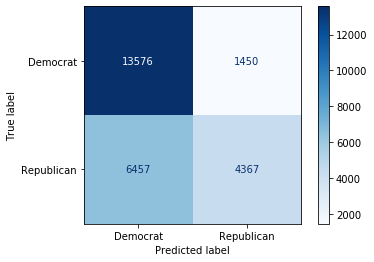

In [112]:
y_pred = gs_clf.predict(X_test)
get_stats(y_test, y_pred)